# Optimal Transport between Gaussian Mixture Models - Simple experiments

This notebook presents simple experiments using a transportation distance between GMM defined by restricting the set of possible coupling measures to Gaussian mixtures. In the following, we denote by $GMM_{d}(\infty)$ the set of probability distributions which can be written as finite Gaussian mixture models on $\mathbb{R}^d$.

Let $\mu_0$ and $\mu_1$ be two Gaussian mixtures on $\mathbb{R}^d$, we define 
 $$GW_2^2(\mu_0,\mu_1) := \inf_{\gamma \in \Pi(\mu_0,\mu_1) \cap GMM_{2d}(\infty)} \int_{\mathbb{R}^d\times\mathbb{R}^d} \|y_0-y_1\|^2d\gamma(y_0,y_1).$$
The problem is well defined since $\Pi(\mu_0,\mu_1) \cap GMM_{2d}(\infty)$ contains at least the product measure $\mu_0 \otimes \mu_1$.
We can show that $GW_2$ defines a distance, and this distance is obvisouly larger than the Wasserstein distance since it has the same definition with a smaller set of constraints. 

Moreover, if $\mu_0 =\sum_{k=1}^{K_0} \pi_0^k \mu_0^k$ and $\mu_1= \sum_{k=1}^{K_1} \pi_1^k \mu_1^k$, it can be shown that
  $$
 GW_2^2(\mu_0,\mu_1) =  \min_{w \in \Pi(\pi_0,\pi_1)} \sum_{k,l}w_{kl} W_2^2(\mu_0^k,\mu_1^l), $$
where $\Pi(\pi_0,\pi_1)$ is the subset of the discrete probability distributions with marginals $\pi_0$ and $\pi_1$, *i.e.*

$$\Pi(\pi_0,\pi_1) = \{w \in \mathcal{M}_{K_0,K_1}(\mathbb{R}^+);\;\forall k,\sum_j w_{kj} = \pi_0^k \text{ and }\forall j,\;\sum_k w_{kj} = \pi_1^j\;\}.$$

See the following references for more information:

[Delon, Desolneux, *A Wasserstein-type distance in the space of Gaussian Mixture Models*, 2019.](https://hal.archives-ouvertes.fr/hal-02178204)

[Chen, Georgiou, Tannenbaum, *Optimal transport for Gaussian mixture models*, 23rd International Symposium on Mathematical Theory of Networks and Systems, 2018](http://mtns2018.ust.hk/media/files/0122.pdf)




In [1]:
# Author: Julie Delon <julie.delon 'at' parisdescartes.fr>

# import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spl
import scipy.stats as sps
%matplotlib inline

# Optimal Transport library https://github.com/rflamary/POT
import ot                 
import ot.plot

# for interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual

ModuleNotFoundError: No module named 'ot'

We import the functions that will be used in this notebook. This functions are contained in the file gmmot.py available with this notebook.

In [ ]:
from gmmot import *

## Optimal Transport between Gaussian Mixture Models in 1D

We start with simple 1D experiments, with 
$$\mu_0 = 0.3 \mathcal{N}(0.2,0.03)+ 0.7\mathcal{N}(0.4,0.04),$$
$$\mu_1 = 0.6 \mathcal{N}(0.6,0.06)+ 0.4\mathcal{N}(0.8,0.07).$$

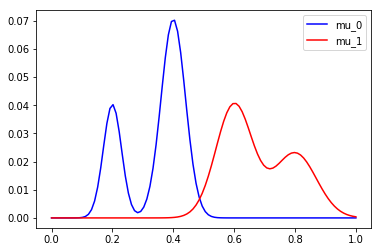

In [3]:
# first GMM
d=1  # space dimension
pi0 = np.array([.3,.7])    
mu0 = np.array([[.2,.4]]).T
S0  = np.array([[[.03]],[[.04]]])
K0  = pi0.shape[0]

# second GMM
pi1 = np.array([.6,.4])    
mu1 = np.array([[.6,.8]]).T   
S1 = np.array([[[.06]],[[.07]]])
K1 = pi1.shape[0]

# GMM densities
n    = 100
x    = np.linspace(0,1,num=n)
gmm0 = densite_theorique(mu0,S0,pi0,x)
gmm0 = gmm0/gmm0.sum()
gmm1 = densite_theorique(mu1,S1,pi1,x)
gmm1 = gmm1/gmm1.sum()

# display densities
plt.plot(x,gmm0,'b',label='mu_0')
plt.plot(x,gmm1,'r',label='mu_1')
plt.legend();

## Transportation maps 

We can compute the traditionnal Wasserstein map between $\mu_0$ and $\mu_1$ thanks to the function `ot.emd` of the POT library.

### For $W_2$

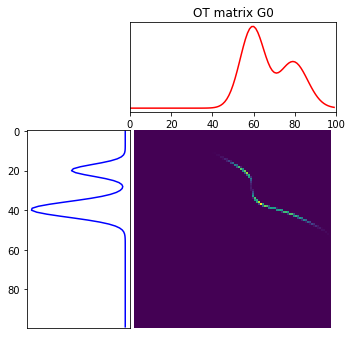

In [4]:
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()
G0 = ot.emd(gmm0, gmm1, M)
plt.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(gmm0, gmm1, G0, 'OT matrix G0')

### For $GW_2$ 

Now we compute the $GW_2$-map. We start by computing the $K0\times K1$ cost matrix between all the Gaussian components of the two mixtures.

In [5]:
wstar,dist = GW2(pi0,pi1,mu0,mu1,S0,S1)
wstar

array([[0.3, 0. ],
       [0.3, 0.4]])

An optimal transport plan between $\mu_0$ and $\mu_1$ for $GW_2$ is given by
$$  \gamma (x,y) = \sum_{k,l} w_{k,l}^\ast g_{m_0^k,\Sigma_0^k}(x)
\delta_{y=T_{k,l}(x)},$$
where $T_{k,l}$ is the $W_2$-optimal map between $\mu_0^k$ and $\mu_1^l$ and $w_{k,l}^\ast$ is a solution of the linear program $\inf_{w \in \Pi(\pi_0,\pi_1)} \sum_{k,l}w_{kl} W_2^2(\mu_0^k,\mu_1^l).$

Moreover, if $(X,Y)$ is distributed according to the law $\gamma$, then 
$$ T_{mean}(x) := \mathbb{E}_\gamma (Y | X=x) = \frac{\sum_{k,l}
w_{k,l}^\ast g_{m_0^k,\Sigma_0^k}(x) T_{k,l}(x)}{\sum_{k} \pi^k_{0} g_{m_0^k,\Sigma_0^k}(x)} .$$

In the following, we compute and display these two maps on a regular grid.

In [2]:
n    = 100
x    = np.linspace(0,1,num=n).reshape(n,1)

Tmap,Tmean = GW2_map(pi0,pi1,mu0,mu1,S0,S1,wstar,x)
plt.figure(3, figsize=(4, 4))
ot.plot.plot1D_mat(gmm0, gmm1, Tmap, 'Tmap')

NameError: name 'np' is not defined

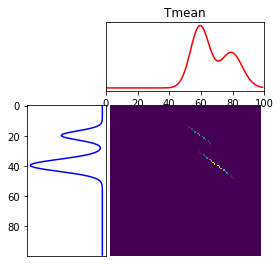

In [7]:
plt.figure(3, figsize=(4, 4))
ot.plot.plot1D_mat(gmm0, gmm1, Tmean, 'Tmean')

## Interpolation 

### Interpolation for $GW_2$

We now compute the interpolation between the two distributions for $GW_2$.

In [8]:
def barygmmot(t):
# Barycenters for GW2
    pit = wstar.reshape(K0*K1,1)
    mut = ((1-t)*mu0+t*mu1.T).reshape(K0*K1,1)
    St = (((1-t) + t*np.sqrt(S1.T/S0))**2*S0).reshape(K0*K1,1,1)
    gmmt = densite_theorique(mut,St,pit,x)
    gmmt = gmmt/gmmt.sum()
    plt.plot(x,gmmt)
    plt.plot(x,gmm0,'r')
    plt.plot(x,gmm1,'k')
    plt.show()

interact(barygmmot,t=(0.0,1.0,0.05))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.barygmmot(t)>

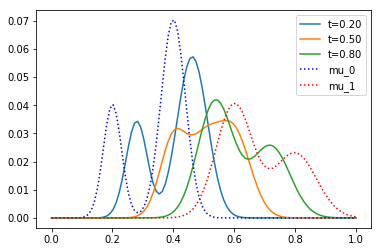

In [9]:
pit = wstar.reshape(K0*K1,1)
for t in [0.2,0.5,.8]:
    mut = ((1-t)*mu0+t*mu1.T).reshape(K0*K1,1)
    St = (((1-t) + t*np.sqrt(S1.T/S0))**2*S0).reshape(K0*K1,1,1)
    gmmt = densite_theorique(mut,St,pit,x)
    gmmt = gmmt/gmmt.sum()
    plt.plot(x,gmmt,label='t=%.2f' %t)
    
plt.plot(x,gmm0,'b:',label='mu_0')
plt.plot(x,gmm1,'r:',label='mu_1')
plt.legend();

### Interpolation for $W_2$

We now compute the interpolation between the two distributions for $W_2$, thanks to the function `ot.barycenter`of the POT library.

In [12]:
# Barycenters for OT
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()
G0 = ot.emd(gmm0, gmm1, M)
A = np.vstack((gmm0, gmm1)).T

def baryot(t):
    weights = np.array([1 - t, t])
    reg = 5*1e-4
    ott = ot.barycenter(A, M, reg, weights)
    plt.plot(x,ott)
    plt.plot(x,gmm0,'r')
    plt.plot(x,gmm1,'k')
    plt.show()

interact(baryot,t=(0.0,1.0,0.05))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.baryot(t)>

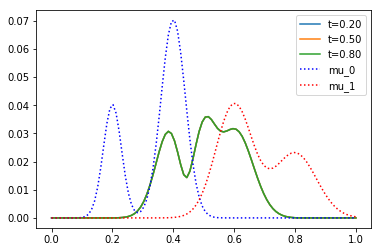

In [13]:
A = np.vstack((gmm0, gmm1)).T
for t in [0.2,0.5,0.8]:
    weights = np.array([1 - t, t])
    reg = 1e-3
    ott = ot.barycenter(A, M, reg, weights)
    plt.plot(x,ott,label='t=%.2f' %t)
plt.plot(x,gmm0,'b:',label='mu_0')
plt.plot(x,gmm1,'r:',label='mu_1')
plt.legend()
plt.show()

## Optimal Transport between Gaussian Mixture Models in 2D

In the second part of this notebook, we illustrate the use of the distance $GW_2$ for two dimensional Gaussian mixtures. We use the following simple mixtures:
$$\mu_0 = 0.5 \mathcal{N}\left(
  \begin{pmatrix}
    0.3\\0.3
  \end{pmatrix}
,0.01 I_2\right)+ 0.5 \mathcal{N}\left(
  \begin{pmatrix}
    0.7\\0.4
  \end{pmatrix}
,0.01 I_2\right),$$
and
$$\mu_1 = 0.45 \mathcal{N}\left(
  \begin{pmatrix}
    0.5\\0.6
  \end{pmatrix}
,0.01 I_2\right)+ 0.55 \mathcal{N}\left(
  \begin{pmatrix}
    0.4\\0.25
  \end{pmatrix}
,0.01 I_2\right),$$
where $I_2$ is the $2\times 2$ identity matrix.

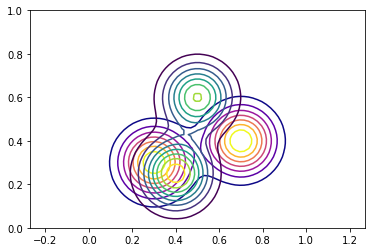

In [3]:
d  = 2 #space dimension

# 2D Gaussian mixtures
K0,K1 = 2,2
pi0 = np.array([[0.5,0.5]])
mu0 = np.array([[0.3,0.3],[0.7,0.4]])
S0 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]]])
pi1 = np.array([[0.45,0.55]])
mu1 = np.array([[0.5,0.6],[0.4,0.25]])
S1 = np.array([[[ .01, 0],[0,  .01]],[[ 0.01, 0],[0,  0.01]]])

# display
n=50    
x = np.linspace(0, 1,num=n)
y = np.linspace(0, 1,num=n)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = densite_theorique2d(mu0,S0,pi0,XX)
Z = Z.reshape(X.shape)
Z2 = densite_theorique2d(mu1,S1,pi1,XX,)
Z2 = Z2.reshape(X.shape)
CS = plt.contour(X, Y, Z,8,cmap='plasma')
CS = plt.contour(X, Y, Z2,8,cmap='viridis')
plt.axis('equal');   

### Interpolation for $GW_2$ 
We compute the K0xK1 cost matrix between the Gaussian members of the mixtures.

In [15]:
wstar,dist = GW2(np.ravel(pi0),np.ravel(pi1),mu0.reshape(K0,d),mu1.reshape(K1,d),S0.reshape(K0,d,d),S1.reshape(K1,d,d))
wstar

array([[0.  , 0.5 ],
       [0.45, 0.05]])

Now we can compute and display the barycenters between $\mu_0$ and $\mu_1$.

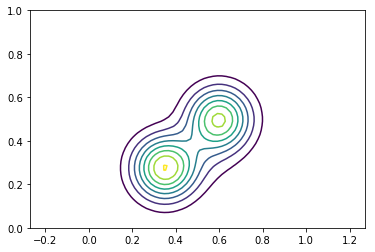

In [16]:
def barygmmot2d(t):
# Barycenters for GW2 in 2d
    pit = wstar.reshape(K0*K1,1).T
    mut = np.zeros((K0*K1,2))
    St  = np.zeros((K0*K1,2,2))
    for k in range(K0):
        for l in range(K1):
            mut[k*K1+l,:]  = (1-t)*mu0[k,:]+t*mu1[l,:]
            Sigma1demi = spl.sqrtm(S1[l,:,:])
            C   = Sigma1demi@spl.inv(spl.sqrtm(Sigma1demi@S0[k,:,:]@Sigma1demi))@Sigma1demi
            St[k*K1+l,:,:] = ((1-t)*np.eye(2)+t*C)@S0[k,:,:]@((1-t)*np.eye(2)+t*C)
    
    # contour plot
    Z = densite_theorique2d(mut,St,pit,XX)
    Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z,8)
    plt.axis('equal')

    
barygmmot2d(0.5)

In [17]:
# interactive display    
interact(barygmmot2d,t=(0.0,1.0,0.05))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.barygmmot2d(t)>

### Interpolation for $W_2$

In the following we display the same barycenters but this time for the $W_2$ distance. The computation between two steps is not instantaneous and can take a few seconds.

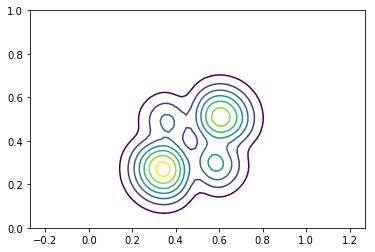

In [4]:
M = ot.dist(XX.reshape((n**2, 2)), XX.reshape((n**2, 2)))
gmm0 = densite_theorique2d(mu0,S0,pi0,XX)
gmm1 = densite_theorique2d(mu1,S1,pi1,XX)
A = []
A.append(gmm0)
A.append(gmm1)
A = np.array(A).T

def baryot(t):
    # Barycenters for W2 in 2d
    weights = np.array([1 - t, t])
    reg = 1e-3
    ott = ot.bregman.barycenter(A, M, reg, weights)
     # contour plot
    Z = ott.reshape(X.shape)
    CS = plt.contour(X, Y, Z, 8)
    plt.axis('equal')


baryot(0.5)

In [6]:
# interactive display    
interact(baryot,t=(0.05,0.96,0.05))

interactive(children=(FloatSlider(value=0.5, description='t', max=0.96, min=0.05, step=0.05), Output()), _dom_…

<function __main__.baryot(t)>